In [1]:
from typing import Dict, List, Union

import empyrical as ep
import gradient_free_optimizers as gfo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qlib
import seaborn as sns
from qlib.data import D

from src import calc_icu_ma, get_backtest, runstrat

# plt中文显示
plt.rcParams["font.sans-serif"] = ["SimHei"]
# plt显示负号
plt.rcParams["axes.unicode_minus"] = False

In [2]:
qlib.init(provider_uri="qlib_data", region="cn")

[42944:MainThread](2023-04-20 15:50:54,508) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[42944:MainThread](2023-04-20 15:50:54,781) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[42944:MainThread](2023-04-20 15:50:54,782) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('D:/WorkSpace/QuantsPlaybook/C-择时类/ICU均线/qlib_data')}


In [3]:
OTO: str = "Ref($open,-1)/Ref($open,-1)-1"
CTC: str = "Ref($close,-1)/$close-1"
hs300: pd.DataFrame = D.features(["000300.SH"], fields=["$close", OTO, CTC])
close_ser: pd.Series = hs300.droplevel(level=0)["$close"]
oto_ret: pd.Series = hs300.droplevel(level=0)[OTO]
ctc_ret: pd.Series = hs300.droplevel(level=0)[CTC]

# ICU均线构造

中泰写的有点绕，应该是使用**重复中位数（RM）下的稳健回归**

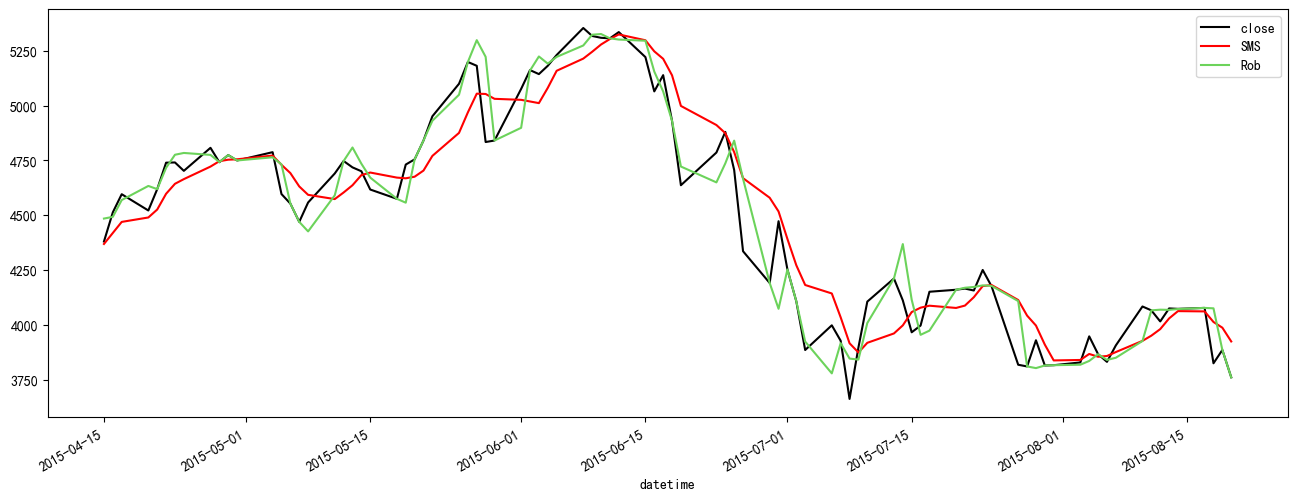

In [4]:
start_dt = pd.to_datetime("2015-04-15")
end_dt = pd.to_datetime("2015-08-20")

rob_ser:pd.Series = calc_icu_ma(close_ser,5)
close_ser.loc[start_dt:end_dt].plot(figsize=(16, 6), label="close", color="black")
close_ser.rolling(5).mean().loc[start_dt:end_dt].plot(color='r', label="SMS")
rob_ser.loc[start_dt:end_dt].plot(label="Rob", color="#6cd35b")
plt.legend()

与研报给出的构造对比

![avatar](img/ma.png)

In [5]:
# 
all_df: pd.DataFrame = pd.concat(
    (
        calc_icu_ma(close_ser,i) for i in np.arange(5, 205, 5)
    ),
    axis=1,
)
all_df.columns = np.arange(5, 205, 5)

In [6]:
# 简单网格寻参
flag_frame: pd.DataFrame = (
    all_df.sub(close_ser, axis=0).mul(-1).apply(lambda x: np.where(x > 0, 1, 0))
)
cum_frame: pd.DataFrame = ep.cum_returns(flag_frame.mul(ctc_ret, axis=0))

In [7]:
cum_frame.iloc[-1].nlargest(10)

10     2.585549
115    1.725991
120    1.708125
110    1.685308
125    1.509107
105    1.389521
150    1.366023
130    1.344796
135    1.282981
140    1.229298
Name: 2023-03-30 00:00:00, dtype: float64

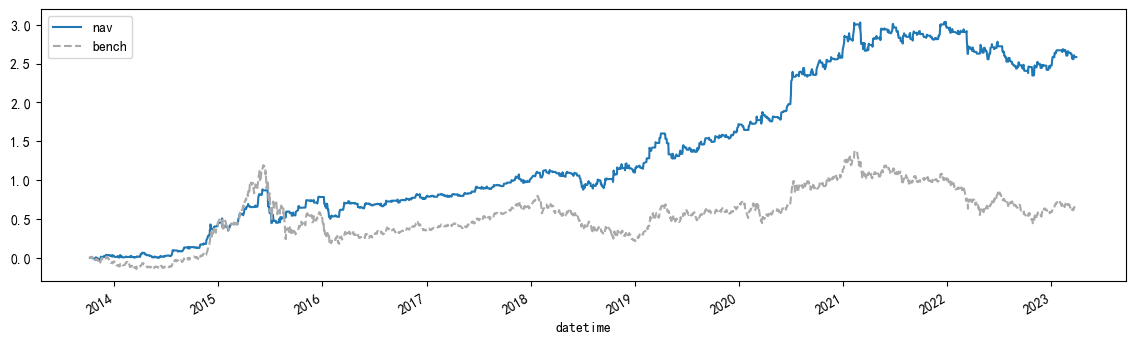

In [8]:
cum_frame[10].plot(label="nav",figsize=(14,4))
ep.cum_returns(close_ser.pct_change()).plot(label="bench", ls="--", color="darkgray")
plt.legend()

# 回测

开仓条件

价格上穿短期 ICU 均线则买入，当价格从上往下穿均线时卖出平仓

$$\begin{cases} Buy_{t}\ if\ Price_{t} > ICUMVG_{t}\ and\ Price_{t-1} < ICUMVG_{t-1} \\
sell_{t}\ if\ Price_{t} < ICUMVG_{t}\ and\ Price_{t-1} > ICUMVG_{t-1}\end{cases}$$

以沪深 300 绝对收益择时策略为例，展示计算流程：
1. 利用过去5个交易日数据滚动计算ICU均线
2. **每日临近收盘计算交易信号，出现信号立刻以收盘价买入.**

但这里我们使用backtrader框架进行寻参

回测设置
1. 滑点万1
2. 双边手续费,佣金万3,印花税千1
3. 根据研报给出的回测规则T日信号T日close买入

In [9]:
hs300: pd.DataFrame = D.features(
    ["000300.SH"], fields="$open,$high,$low,$close,$volume".split(",")
)
hs300.columns = hs300.columns.str.replace("$", "", regex=True)
hs300: pd.DataFrame = hs300.droplevel(level=0)

In [10]:
search_space: Dict = {"N": np.arange(5, 205, 5)}

iterations: int = 20

# func = partial(runstrat,dataset=hs300)
opt = gfo.EvolutionStrategyOptimizer(search_space)
opt.search(lambda x: runstrat(x, dataset=hs300,method='ann'), n_iter=iterations)


Results: '<lambda>'  
   Best score: 10.30310430760637  
   Best parameter:
      'N' : 120  
 
   Random seed: 1777858647  
 
   Evaluation time   : 9.181264638900757 sec    [99.88 %]
   Optimization time : 0.011020183563232422 sec    [0.12 %]
   Iteration time    : 9.19228482246399 sec    [2.18 iter/sec]
 


<Axes: ylabel='N'>

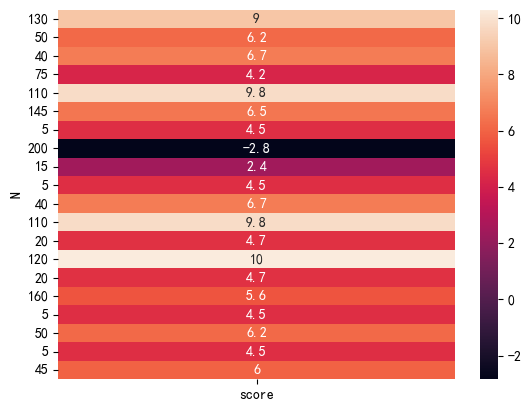

In [11]:
sns.heatmap(opt.search_data.set_index('N'),annot=True)

In [12]:
print(opt.best_para)

{'N': 120}


In [13]:
result = get_backtest(hs300,**opt.best_para)

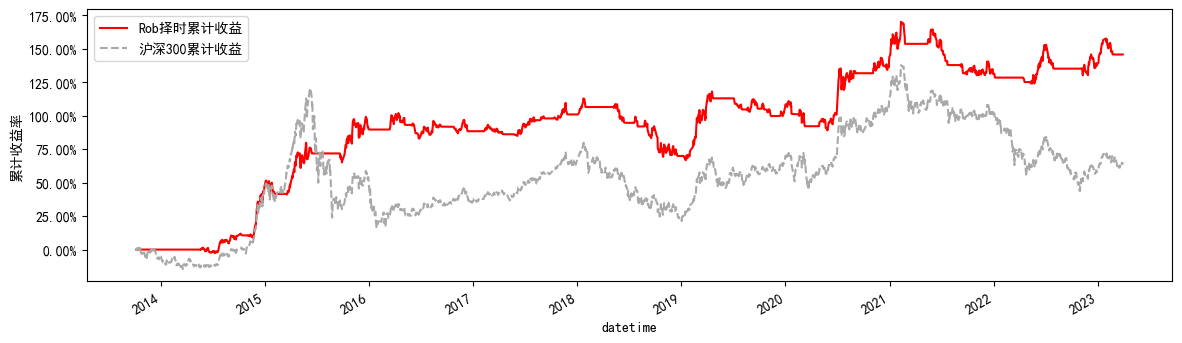

In [14]:
ret = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
ax = ep.cum_returns(ret).plot(figsize=(14, 4), label="Rob择时累计收益", color="r")
ep.cum_returns(hs300["close"].pct_change()).plot(
    ls="--", color="darkgray", label="沪深300累计收益", ax=ax
)
ax.set_ylabel('累计收益率')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
plt.legend()

对比研报回测结果:

![avatar](img/2.png)

# 目标函数设置 

使用信号值与资产对数收益之间的相关系数

[量化策略开发与可微编程（二）：目标函数](https://zhuanlan.zhihu.com/p/262008747)

In [15]:
def search_single_ma_para(close_ser: pd.Series, periods: Dict) -> float:
    N: int = np.int32(periods["N"])

    if N >= len(close_ser):
        raise ValueError("N is too large")

    signal: pd.Series = calc_icu_ma(close_ser, N)
    log_ret: pd.Series = np.log(close_ser / close_ser.shift(1))

    flag: pd.Series = np.tanh(close_ser - signal)
    return np.corrcoef(flag.iloc[N:], log_ret.iloc[N:])[0, 1]


def search_double_ma_para(close_ser: pd.Series, periods: Dict) -> float:
    N: int = np.int32(periods["N"])
    M: int = np.int32(periods["M"])

    # N 必须小于 M
    if N >= M:
        return np.nan

    if M >= len(close_ser):
        raise ValueError("N is too large")

    fast_ma: pd.Series = calc_icu_ma(close_ser, N)
    slow_ma: pd.Series = fast_ma.rolling(M).mean()
    log_ret: pd.Series = np.log(close_ser / close_ser.shift(1))

    flag: pd.Series = np.tanh(fast_ma - slow_ma)

    return np.corrcoef(flag.iloc[(M + N) :], log_ret.iloc[(M + N) :])[0, 1]

In [16]:
search_space: Dict = {"N": np.arange(5, 405, 5), "M": np.arange(5, 605, 5)}

iterations: int = 250

# func = partial(runstrat,dataset=hs300)
# HillClimbingOptimizer
# EvolutionStrategyOptimizer
opt = gfo.EvolutionStrategyOptimizer(search_space,population=20)
# opt.search(lambda x: search_double_ma_para(close_ser,periods=x), n_iter=iterations)
opt.search(lambda x: search_double_ma_para(close_ser,periods=x), n_iter=iterations)


Results: '<lambda>'  
   Best score: 0.052932770916599925  
   Best parameter:
      'N' : 15  
      'M' : 20  
 
   Random seed: 2007572018  
 
   Evaluation time   : 88.80985522270203 sec    [99.87 %]
   Optimization time : 0.11672472953796387 sec    [0.13 %]
   Iteration time    : 88.92657995223999 sec    [2.81 iter/sec]
 


In [17]:
search_data: pd.DataFrame = opt.search_data.copy()
search_data["Sharpe"] = 0
search_data["CumRet"] = 0
for idx, rows in search_data.iterrows():
    N = np.int16(rows["N"])
    M = np.int16(rows["M"])
    fast_ma: pd.Series = calc_icu_ma(close_ser, N)
    slow_ma: pd.Series = fast_ma.rolling(M).mean()

    flag: pd.Series = (fast_ma - slow_ma).apply(lambda x: np.where(x > 0, 1, 0))
    ret: pd.Series = flag * close_ser.pct_change().shift(-1)

    search_data.loc[idx, "Sharpe"] = ep.sharpe_ratio(ret)
    search_data.loc[idx, "CumRet"] = ep.cum_returns(ret).iloc[-1]

<Axes: xlabel='score', ylabel='CumRet'>

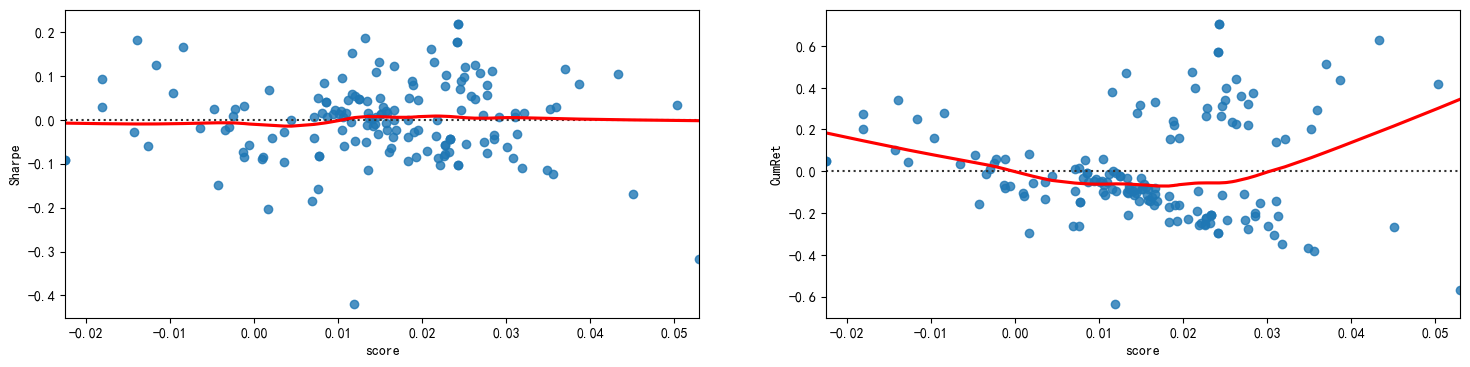

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
sns.residplot(
    search_data,
    x="score",
    y="Sharpe",
    lowess=True,
    line_kws=dict(color="r"),
    ax=axes[0],
)
sns.residplot(
    search_data,
    x="score",
    y="CumRet",
    lowess=True,
    line_kws=dict(color="r"),
    ax=axes[1],
)